In [5]:
from sklearn.svm import SVC # Support Vector Classifier for anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.svm import OneClassSVM

Precision: 0.8181818181818182
Recall: 0.005451241671714113
F1 Score: 0.010830324909747294


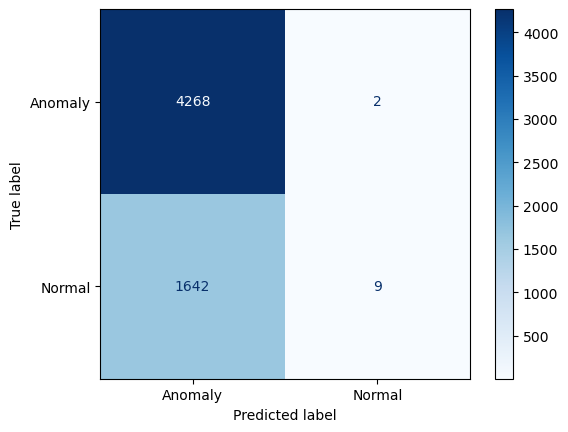

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      4270
           1       0.82      0.01      0.01      1651

    accuracy                           0.72      5921
   macro avg       0.77      0.50      0.42      5921
weighted avg       0.75      0.72      0.61      5921



In [11]:

def hybrid_anomaly_detection_with_isolation_forest_first():
    
    # Load dataset
    data = pd.read_csv('energydata.csv')
    
    data = data.drop('date', axis=1)
    
    X = data.drop('Windspeed', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['Windspeed']
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    data.dropna(axis=0, inplace=True)
    
#     #Scatter plot
#     sns.pairplot(data, kind='scatter')
#     plt.title('Scatter Plot')
#     plt.show()
    
    
    y = np.where(y_cont > 5, 1, 0)  # Define `threshold` based on the dataset
    
        
    # Select top k features; you might adjust k based on your dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    X_selected
    
    # Initialize and fit Isolation Forest
    iso_forest = IsolationForest(contamination=0.1)  # adjust contamination as needed
    iso_predictions = iso_forest.fit_predict(X_selected)

    # Convert Isolation Forest output from {-1, 1} to {0, 1} (0 for anomaly, 1 for normal)
    iso_predictions = np.where(iso_predictions == 1, 0, 1)  # flipping the labels for consistency with target
    
    # Add Isolation Forest predictions as a feature
    X_extended = X.copy()
    X_extended['iso_forest_outcome'] = iso_predictions
    
    
    # Split the extended dataset for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_extended, y, test_size=0.3, random_state=42)

    # Initialize and fit SVM
    svm_model = OneClassSVM(kernel='rbf', gamma='auto')
    svm_model.fit(X_train[y_train == 1])  # Train only on normal data

    # Predict on test data
    svm_predictions = svm_model.predict(X_test)
    svm_predictions = np.where(svm_predictions == 1, 1, 0)  # Convert {-1, 1} to {0, 1}
    
    
    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, svm_predictions)
    recall = recall_score(y_test, svm_predictions)
    f1 = f1_score(y_test, svm_predictions)

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, svm_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
        # Evaluation
    precision = precision_score(y_test, svm_predictions)
    recall = recall_score(y_test, svm_predictions)
    f1 = f1_score(y_test, svm_predictions)
    
    print(classification_report(y_test, svm_predictions))

# Usage Example
# Assuming X and y are defined, where X is your feature set and y are your labels (1 for normal, -1 for anomalies)
hybrid_anomaly_detection_with_isolation_forest_first()
